<a href="https://colab.research.google.com/github/Rigboone-68/Data-Science-DEP/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Step 1: Installing the required libraries and authenticating the Kaggle API
!pip install kaggle
from google.colab import files

# Uploading the kaggle.json file
files.upload()

# Setting up the Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading a sample dataset (e.g., Online Retail Dataset) from Kaggle
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

# Unzipping the dataset
!unzip ecommerce-behavior-data-from-multi-category-store.zip


ERROR: Operation cancelled by user


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
... resuming from 2004877312 bytes (2601843595 bytes left) ...
100% 4.27G/4.29G [00:21<00:00, 159MB/s]
100% 4.29G/4.29G [00:21<00:00, 121MB/s]
Archive:  ecommerce-behavior-data-from-multi-category-store.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


In [6]:
# Step 2: Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Step 3: Loading and inspecting the dataset
df = pd.read_csv('2019-Oct.csv')

# To Display a few rows of the dataset
df.head()

# Checking for the missing values
df.isnull().sum()

# Filtering only relevant columns (for simplicity: 'event_type', 'price', 'user_id', 'category_code', etc.)
df = df[['user_id', 'event_type', 'price', 'category_code', 'event_time']] # Changed 'timestamp' to 'event_time'

# Dropping the rows with missing 'price'
df.dropna(subset=['price'], inplace=True)

# Converting timestamp to a datetime object
df['event_time'] = pd.to_datetime(df['event_time']) # Changed 'timestamp' to 'event_time'

In [10]:
# Step 4: Creating RFM features (Recency, Frequency, Monetary)

# Recency: Days since last purchase for each user
df['Recency'] = df['event_time'].max() - df.groupby('user_id')['event_time'].transform('max')
df['Recency'] = df['Recency'].dt.days

# Frequency: Number of purchases per user
frequency = df.groupby('user_id').size().reset_index(name='Frequency')

# Monetary: Total amount spent by each user
monetary = df.groupby('user_id')['price'].sum().reset_index(name='Monetary')

# Merging all into a single dataframe
rfm_df = df.groupby('user_id').agg({'Recency': 'min'}).reset_index()
rfm_df = pd.merge(rfm_df, frequency, on='user_id')
rfm_df = pd.merge(rfm_df, monetary, on='user_id')

# Checking the resulting RFM table
rfm_df.head()


,user_id,Recency,Frequency,Monetary
0,33869381,8,1,769.65
1,64078358,18,1,0.00
2,183503497,29,1,15.77
3,184265397,16,6,670.24
4,195082191,21,1,161.88


In [11]:
# Step 5: Standardizing the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


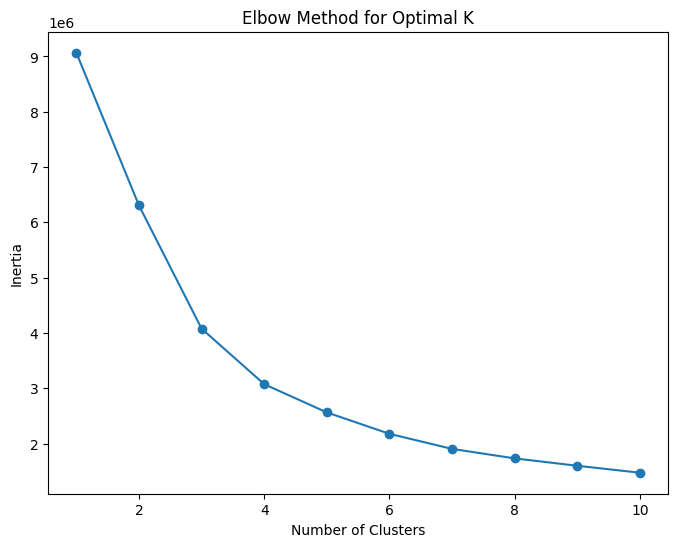

In [12]:
# Step 6: Using Elbow method to find optimal k for KMeans clustering
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow chart
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [13]:
# Step 7: Applying K-means clustering with the optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Check the resulting clusters
rfm_df.head()


,user_id,Recency,Frequency,Monetary,Cluster
0,33869381,8,1,769.65,0
1,64078358,18,1,0.00,1
2,183503497,29,1,15.77,1
3,184265397,16,6,670.24,1
4,195082191,21,1,161.88,1


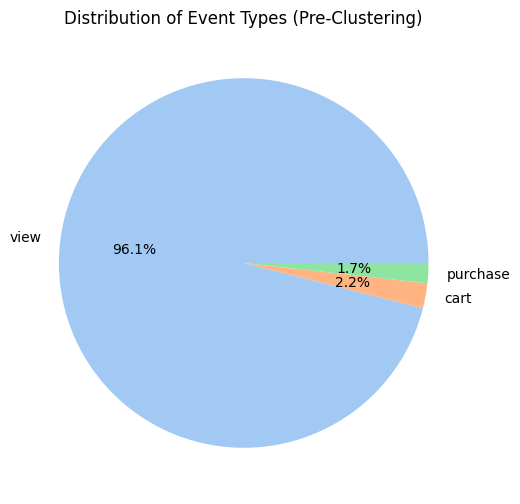

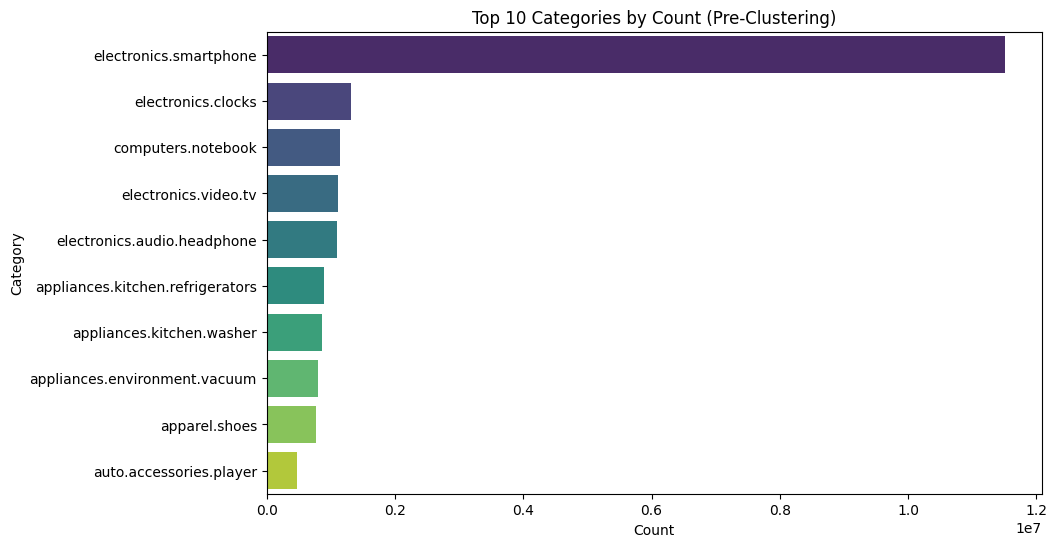

In [15]:
# Importing necessary libraries again (not necessary but wanted to be safe than sorry)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Pie Chart for Distribution of Event Types (pre-clustering)
event_counts = df['event_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Event Types (Pre-Clustering)')
plt.show()

# Step 2: Bar Chart for Category-wise Distribution
category_counts = df['category_code'].value_counts().head(10)  # Top 10 categories for simplicity

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Top 10 Categories by Count (Pre-Clustering)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


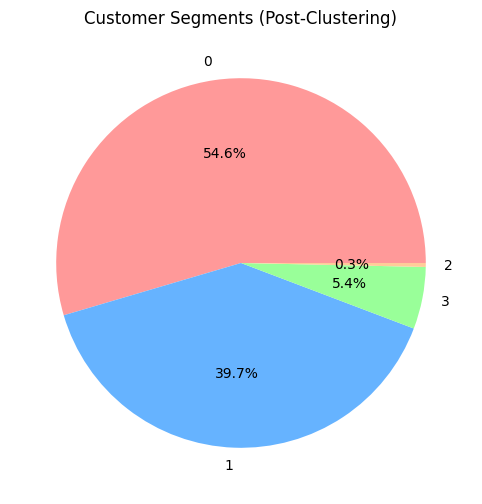

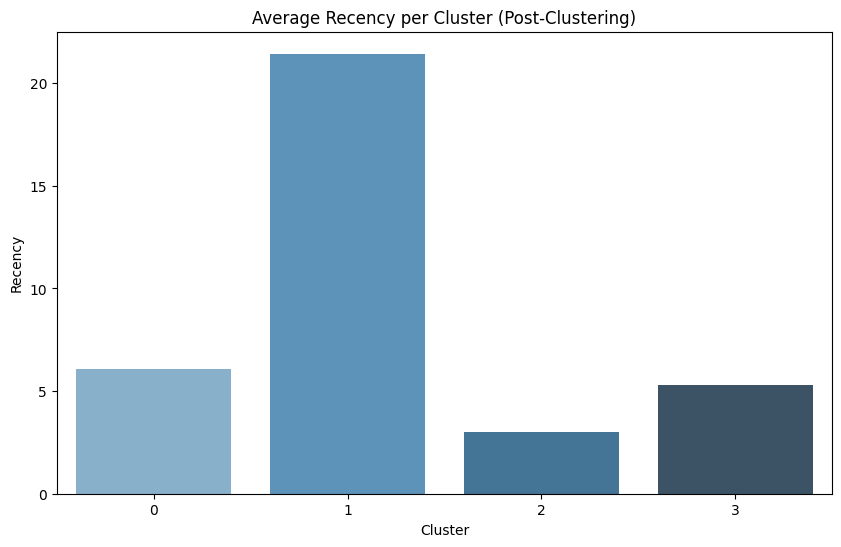

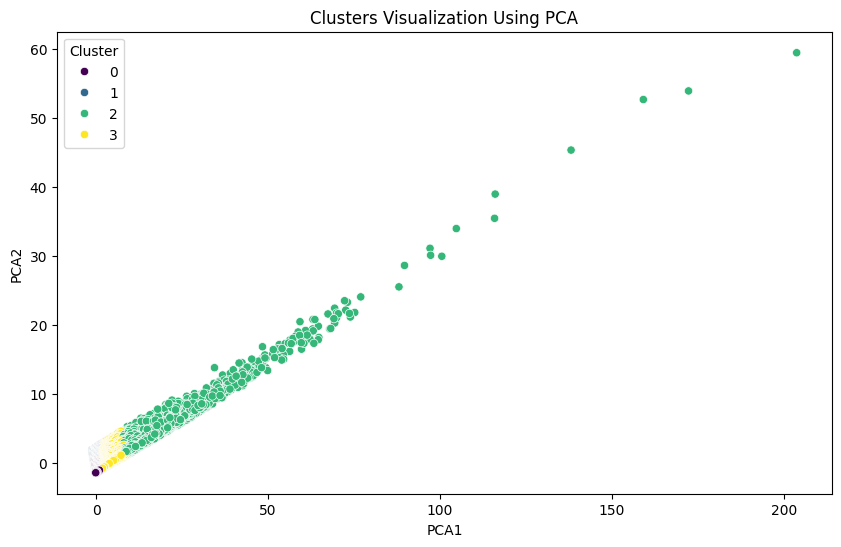

In [19]:
# Step 8: Visualizing the customer segments

# Pie Chart: Distribution of Clusters
cluster_counts = rfm_df['Cluster'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Customer Segments (Post-Clustering)')
plt.show()

# Bar Chart: Average RFM values per cluster
cluster_avg = rfm_df.groupby('Cluster').mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Recency', data=cluster_avg, palette='Blues_d')
plt.title('Average Recency per Cluster (Post-Clustering)')
plt.show()

# Scatter Plot: Cluster visualization using PCA
pca = PCA(2)
pca_data = pca.fit_transform(rfm_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm_df['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Clusters Visualization Using PCA')
plt.show()


In [16]:
# Analyzing the results and exploring further insights, like which customer segment is high-value and how the business can use this information for targeted marketing.

cluster_avg[['Cluster', 'Recency', 'Frequency', 'Monetary']]


,Cluster,Recency,Frequency,Monetary
0,0,6.075967,10.371775,2749.439185
1,1,21.431656,6.140392,1759.787591
2,2,3.011390,333.075000,118429.263500
3,3,5.301064,88.632787,27159.222282
